In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import sequence
from keras.models import Sequential , load_model
from keras.layers import Dense, Dropout , LSTM , Bidirectional ,GRU
from keras_layer_normalization import LayerNormalization
from keras.initializers import  glorot_normal, RandomUniform
from keras import optimizers
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Using TensorFlow backend.


In [2]:
df = pd.read_csv("london_merged.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


In [3]:
training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(17414, 13) (15673, 13) (1765, 13)


In [4]:
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)
train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [5]:
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/15649 [00:00<?, ?it/s]

In [6]:
#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1741 [00:00<?, ?it/s]

Train size:
(15649, 24, 12) (15649,)
Test size:
(1741, 24, 12) (1741,)


In [39]:
from keras import regularizers

init = glorot_normal(seed=None) # 給 LSTM
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer
nadam = optimizers.Nadam(lr=0.0015,clipvalue=0.5)

model = Sequential()
model.add(Bidirectional(GRU(64, kernel_initializer=init ,return_sequences = True,kernel_regularizer=regularizers.l2(0.01)
                             ,recurrent_regularizer = regularizers.l2(0.01) ,input_shape=(x_train.shape[1],x_train.shape[2]))))
model.add(LayerNormalization())
model.add(Bidirectional(GRU(64,kernel_initializer=init,kernel_regularizer=regularizers.l2(0.01),recurrent_regularizer = regularizers.l2(0.01))))
model.add(Dropout(0.1))
model.add(Dense(units=1, kernel_initializer=init_d))
model.compile(optimizer = nadam , loss="mse")
history = model.fit(x_train, y_train, epochs=200, batch_size=24, validation_split=0.1, shuffle=True)
#model summary
model.summary()
#Save Model
model.save('GRU_model_2.h5')  # creates a HDF5 file 
print('Model Saved')
del model  # deletes the existing model

Train on 14084 samples, validate on 1565 samples
Epoch 1/200
14084/14084 [==============================] - 48s 3ms/step - loss: 0.8598 - val_loss: 0.4341
Epoch 2/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.2922 - val_loss: 0.3230
Epoch 3/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.2327 - val_loss: 0.2515
Epoch 4/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.1930 - val_loss: 0.1757
Epoch 5/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.1684 - val_loss: 0.1634
Epoch 6/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.1538 - val_loss: 0.1770
Epoch 7/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.1456 - val_loss: 0.1463
Epoch 8/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.1391 - val_loss: 0.1729
Epoch 9/200
14084/14084 [==============================] - 47s 3ms/step - loss: 0.1341 - val_loss: 0.11

14084/14084 [==============================] - 41s 3ms/step - loss: 0.0818 - val_loss: 0.1082
Epoch 154/200
14084/14084 [==============================] - 40s 3ms/step - loss: 0.0822 - val_loss: 0.1046
Epoch 155/200
14084/14084 [==============================] - 41s 3ms/step - loss: 0.0816 - val_loss: 0.0872
Epoch 156/200
14084/14084 [==============================] - 40s 3ms/step - loss: 0.0835 - val_loss: 0.1023
Epoch 157/200
14084/14084 [==============================] - 41s 3ms/step - loss: 0.0800 - val_loss: 0.0747
Epoch 158/200
14084/14084 [==============================] - 41s 3ms/step - loss: 0.0833 - val_loss: 0.0961
Epoch 159/200
14084/14084 [==============================] - 41s 3ms/step - loss: 0.0841 - val_loss: 0.0815
Epoch 160/200
14084/14084 [==============================] - 41s 3ms/step - loss: 0.0831 - val_loss: 0.0932
Epoch 161/200
14084/14084 [==============================] - 41s 3ms/step - loss: 0.0819 - val_loss: 0.1095
Epoch 162/200
14084/14084 [===============

In [40]:
import time
# layernormalization 屬於自訂義層,直接load model 會報錯
custom_ob = {'LayerNormalization': LayerNormalization}
model = load_model('GRU_model_2.h5', custom_objects=custom_ob)
t1 = time.time()
y_pred = model.predict(x_test)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling
#y_pred

Predict time:  0.994213342666626


In [41]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ',rmse_lstm)

r2 =  r2_score(y_test, y_pred)
print('R-square: ',r2)

n = len(y_test)
p = 12
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adj R-square: ',r2)

RMSE:  412.87099333505495
R-square:  0.802564605309356
Adj R-square:  0.802564605309356


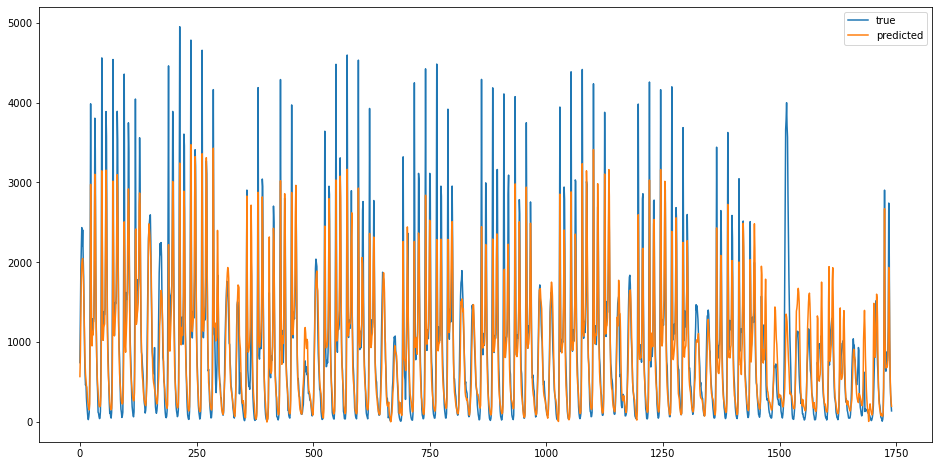

In [42]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.legend()

Text(0, 0.5, 'mse score')

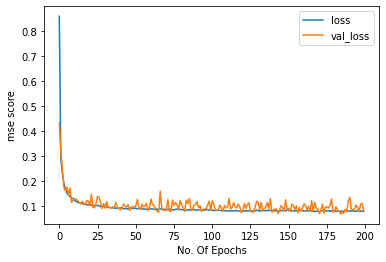

In [43]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

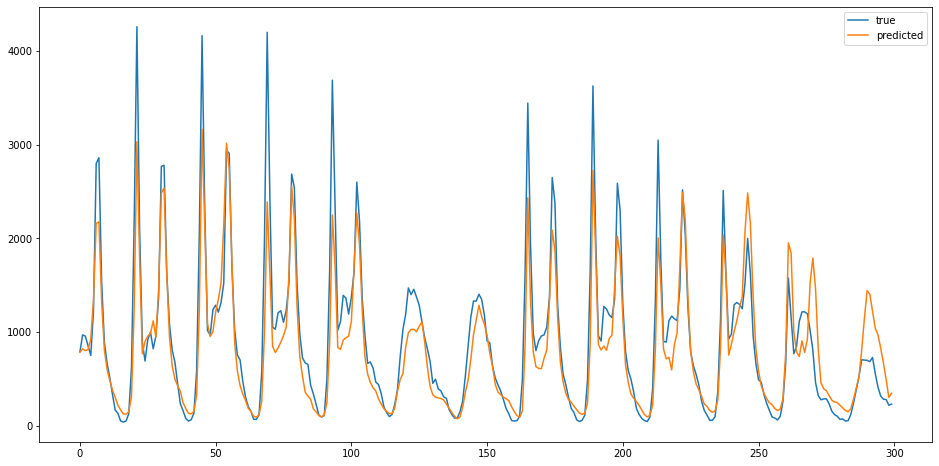

In [44]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1500], label='true')
plt.plot(y_pred[1200:1500], label='predicted')
plt.legend()